<a href="https://colab.research.google.com/github/KatHaruto/PINNs_example/blob/main/SFHCPINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

difference between $SFHCPINN_{NN}$ and $SFHCPINN$ is whether distance function adn extension functino are numerically determined , or computed using NN that trained before PINNs training.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
%mkdir -p /content/drive/MyDrive/PINNs/
%cd /content/drive/MyDrive/PINNs/

/content/drive/MyDrive/PINNs


In [23]:
# !pip install wandb

from google.colab import userdata
import wandb
wandb.login(key=userdata.get('WANDB_API_KEY'))


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: katharuto (katharuto-university-of-tokyo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import sys
sys.version

'3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]'

In [3]:
from functools import partial
from abc import ABC, abstractmethod
from typing import Literal,TypeAlias, Protocol, Callable # type alias statement requires Python 3.12 or newer
import warnings

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from scipy.stats import qmc


Mounted at /content/drive


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:


SAMPLING_STRATEGY: TypeAlias = Literal["uniform", "LHS", "Sobol"] # todo: "adaptive"


In [6]:
class Problem(ABC):
  def __init__():
    pass

  @abstractmethod
  def pde_residual():
    raise NotImplementedError

class NeumannProblem(Problem):
  def __init__(self):
    pass

  @abstractmethod
  def bc_residual():
    raise NotImplementedError

In [7]:
class DirichletADE1D(Problem):
  def __init__(self, alpha:float = 0.1, beta:float = 30, p: float = 0.02, q: float = 0.01) -> None:
    self.alpha = alpha
    self.beta = beta
    self.p = p
    self.q = q

  def analytical_u(self, X: torch.Tensor):
    x, t = X[:,0:1], X[:,1:2]
    return torch.exp(-self.alpha * t) * (
        torch.sin(torch.pi * x) + 0.1 * torch.sin(self.beta * torch.pi * x)
    )

  def _analytical_du_dt(self, X: torch.Tensor) -> torch.Tensor:
    x, t = X[:,0:1], X[:,1:2]
    return -self.alpha * self.analytical_u(X)

  def _analytical_du_dx(self, X: torch.Tensor) -> torch.Tensor:
    x, t = X[:,0:1], X[:,1:2]
    return torch.exp(-self.alpha * t) * (
        torch.pi * torch.cos(torch.pi * x) + 0.1 * self.beta * torch.pi * torch.cos(self.beta * torch.pi * x)
    )

  def _analytical_d2u_dx2(self, X: torch.Tensor) -> torch.Tensor:
    x,t = X[:,0:1], X[:,1:2]
    return torch.exp(-self.alpha * t) * (
        - torch.pi**2 * torch.sin(torch.pi * x) - 0.1 * (self.beta * torch.pi)**2 * torch.sin(self.beta * torch.pi * x))

  def source_function(self, X: torch.Tensor) -> torch.Tensor:
    return self._analytical_du_dt(X) - self.p * self._analytical_d2u_dx2(X) + self.q * self._analytical_du_dx(X)

  def initial_condition(self, X: torch.Tensor) -> torch.Tensor:
    pass

  def boundary_condition(self, X: torch.Tensor) -> torch.Tensor:
    pass

  def pde_residual(self, u: torch.Tensor, X:torch.Tensor) -> torch.Tensor:

    assert u.shape[1] == 1
    assert X.shape[1] == 2

    grad_u = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True,retain_graph=True)[0]
    du_dx = grad_u[:,0:1]
    du_dt = grad_u[:,1:2]

    # 2次微分
    d2u_dx2 = torch.autograd.grad(du_dx, X, torch.ones_like(du_dx), create_graph=True,retain_graph=True)[0][:,0:1]

    S_val = self.source_function(X)

    # PDE残差
    res = du_dt - self.p * d2u_dx2 + self.q * du_dx - S_val

    return res

In [8]:
class NeumannADE1D(NeumannProblem):
  def __init__(self, alpha:float = 0.25, beta:float = 10, p: float = 0.002, q: float = 0.001) -> None:
    self.alpha = alpha
    self.beta = beta
    self.p = p
    self.q = q

  def analytical_u(self, X: torch.Tensor):
    x, t = X[:,0:1], X[:,1:2]
    return torch.exp(-self.alpha * t) * (
        torch.sin(torch.pi * x) + 0.1 * torch.sin(self.beta * torch.pi * x)
    )

  def _analytical_du_dt(self, X: torch.Tensor) -> torch.Tensor:
    x, t = X[:,0:1], X[:,1:2]
    return -self.alpha * self.analytical_u(X)

  def _analytical_du_dx(self, X: torch.Tensor) -> torch.Tensor:
    x, t = X[:,0:1], X[:,1:2]
    return torch.exp(-self.alpha * t) * (
        torch.pi * torch.cos(torch.pi * x) + 0.1 * self.beta * torch.pi * torch.cos(self.beta * torch.pi * x)
    )

  def _analytical_d2u_dx2(self, X: torch.Tensor) -> torch.Tensor:
    x,t = X[:,0:1], X[:,1:2]
    return torch.exp(-self.alpha * t) * (
        - torch.pi**2 * torch.sin(torch.pi * x) - 0.1 * (self.beta * torch.pi)**2 * torch.sin(self.beta * torch.pi * x))

  def source_function(self, X: torch.Tensor) -> torch.Tensor:
    return self._analytical_du_dt(X) - self.p * self._analytical_d2u_dx2(X) + self.q * self._analytical_du_dx(X)

  def initial_condition(self, X: torch.Tensor) -> torch.Tensor:
    pass

  def bc_residual(self, u: torch.Tensor, X: torch.Tensor) -> torch.Tensor:
    du_dx = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True,retain_graph=True)[0][:,0:1]
    return du_dx - self._analytical_du_dx(X)

  def pde_residual(self, u: torch.Tensor, X:torch.Tensor) -> torch.Tensor:

    assert u.shape[1] == 1
    assert X.shape[1] == 2

    grad_u = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True,retain_graph=True)[0]
    du_dx = grad_u[:,0:1]
    du_dt = grad_u[:,1:2]

    # 2次微分
    d2u_dx2 = torch.autograd.grad(du_dx, X, torch.ones_like(du_dx), create_graph=True,retain_graph=True)[0][:,0:1]

    S_val = self.source_function(X)

    # PDE残差
    res = du_dt - self.p * d2u_dx2 + self.q * du_dx - S_val

    return res

In [9]:
class DirichletADE2D(Problem):
  def __init__(self, alpha:float = 0.25, p: float = 4., q: float = 4.) -> None:
    self.alpha = alpha
    self.p = p
    self.q = q

  def analytical_u(self, X: torch.Tensor):
    x, y, t = X[:,0:1], X[:,1:2], X[:,2:3]
    return torch.exp(-self.alpha * t) * (
       x * y * (4 - x ) * (4 - y)
    )

  def _analytical_du_dt(self, X: torch.Tensor) -> torch.Tensor:
    x, y, t = X[:,0:1], X[:,1:2], X[:,2:3]
    return -self.alpha * self.analytical_u(X)

  def _analytical_du_dx(self, X: torch.Tensor) -> torch.Tensor:
    x, y, t = X[:,0:1], X[:,1:2], X[:,2:3]
    return torch.exp(-self.alpha * t) * y * (4 - y) * (4- 2 * x)

  def _analytical_d2u_dx2(self, X: torch.Tensor) -> torch.Tensor:
    x, y, t = X[:,0:1], X[:,1:2], X[:,2:3]
    return - torch.exp(-self.alpha * t) * 2 * y * (4 - y)

  def _analytical_du_dy(self, X: torch.Tensor) -> torch.Tensor:
    x, y, t = X[:,0:1], X[:,1:2], X[:,2:3]
    return torch.exp(-self.alpha * t) * x * (4 - x) * (4 - 2 * y)

  def _analytical_d2u_dy2(self, X: torch.Tensor) -> torch.Tensor:
    x, y, t = X[:,0:1], X[:,1:2], X[:,2:3]
    return - torch.exp(-self.alpha * t) * 2 * x * (4 - x)

  def source_function(self, X: torch.Tensor) -> torch.Tensor:
    return self._analytical_du_dt(X) + self.p * self._analytical_du_dx(X) + self.q * self._analytical_du_dy(X) - (self._analytical_d2u_dx2(X) + self._analytical_d2u_dy2(X))

  def pde_residual(self, u: torch.Tensor, X:torch.Tensor) -> torch.Tensor:

    assert u.shape[1] == 1
    assert X.shape[1] == 3

    grad_u = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True,retain_graph=True)[0]
    du_dx = grad_u[:,0:1]
    du_dy = grad_u[:,1:2]
    du_dt = grad_u[:,2:3]

    # 2次微分
    grad_du = torch.autograd.grad(grad_u, X, torch.ones_like(grad_u), create_graph=True,retain_graph=True)[0]
    d2u_dx2 = grad_du[:,0:1]
    d2u_dy2 = grad_du[:,1:2]


    S_val = self.source_function(X)

    # PDE残差
    res = du_dt + self.p * du_dx + self.q * du_dy - (d2u_dx2 + d2u_dy2) - S_val

    return res

In [10]:
class Sin(nn.Module):
  def __init__(self):
    super(Sin, self).__init__()
  def forward(self, x):
    return torch.sin(x)

class FourierFeatureLayer(nn.Module):
    def __init__(self,input_dim, hidden_size, k):
      super(FourierFeatureLayer, self).__init__()
      self.k = k
      self.w = nn.Linear(input_dim, hidden_size)

    def forward(self, x):
      x = self.w(self.k * x)
      return torch.cat([torch.cos(x), torch.sin(x)] , dim=1)

class PINN(nn.Module):
  def __init__(self, *, input_dim, output_dim, hidden_size_list):
    super(PINN, self).__init__()
    layers = []

    for hidden_size in hidden_size_list:
        layers.append(nn.Linear(input_dim, hidden_size))
        layers.append(Sin())
        input_dim = hidden_size
    layers.append(nn.Linear(input_dim, output_dim))

    self.layers = nn.Sequential(*layers)



  def forward(self, x):
    return self.layers(x)


class SFPINN(nn.Module):
  def __init__(self, *, input_dim, output_dim,  subn_hidden_size_list: list[list[int]], frequencies: list[int]):
    super(SFPINN, self).__init__()

    if len(subn_hidden_size_list) != len(frequencies):
      raise ValueError("subn_hidden_size_list and frequencies must have the same length")

    self.subnetworks = nn.ModuleList(
        [
            nn.Sequential(
              FourierFeatureLayer(
                  input_dim,
                  hidden_size_list[0],
                  freq
              ),
              PINN(
                input_dim=hidden_size_list[0] * 2,
                output_dim=output_dim,
                hidden_size_list=hidden_size_list[1:]
              )
            )
            for hidden_size_list,freq in zip(subn_hidden_size_list, frequencies)
        ]
    )

    self.w = nn.Linear(output_dim * len(frequencies), output_dim)



  def forward(self, x):
    out = torch.cat([subn(x) for subn in self.subnetworks], dim=1)
    return self.w(out)


class SFHCPINN(SFPINN):
  def __init__(
      self,
      *,
      input_dim: int,
      output_dim: int,
      subn_hidden_size_list: list[list[int]],
      frequencies: list[int],
      dist_func: Callable[[torch.tensor], torch.tensor],
      extension_func: Callable[[torch.tensor], torch.tensor],
    ):
    super(SFHCPINN, self).__init__(
        input_dim=input_dim,
        output_dim=output_dim,
        subn_hidden_size_list=subn_hidden_size_list,
        frequencies=frequencies
    )

    self.dist_func = dist_func
    self.extention_func = extension_func

  def forward(self, x):
    out = torch.cat([subn(x) for subn in self.subnetworks], dim=1)

    return self.extention_func(x) + self.dist_func(x) * self.w(out)



# one dimensional ADE

## Governing Equation
$$
\frac{\partial u(x,t)}{\partial t}  = \tilde{p} \frac{\partial^2u(x,t)}{\partial t} - \tilde{q} \frac{\partial u(x,t)}{\partial x} + f(x,t), for\,x \in [a,b]\, and\, t \in [t_0,T]
$$

### I/C and B/C
$$
u(x,t_0) = A_0(x), \\
u(a,t) = A_1(t), \\
u(b,t) = A_2(t), \\
\frac{\partial u(a,t)}{\partial x} = N_1(t), \\
\frac{\partial u(b,t)}{\partial x} = N_2(t)
$$

### Solution is folloing equation
$$
u(x,t) =  e^{-\alpha t}[sin(\pi x) + 0.1 sin(\beta \pi x)]
$$

In [11]:
epoch = 50_000
N_r = 8_000
N_b = 3_000

## SFHCPINN does not need initial/boundary points.
# N_b = 4_000
# N_i = 3_000

initial_lr = 0.01
decay_rate = 0.975
decay_step_size = 100

gamma_0 = 20




In [12]:
class BaseSampler(ABC):
  def __init__(self,dim: int): pass

  @abstractmethod
  def sample(self, boundary: np.ndarray, num) -> np.ndarray:
    raise NotImplementedError

class UniformSampler(BaseSampler):
  def __init__(self,dim) -> None:
    self.dim = dim

  def sample(self, boundary:np.ndarray, num:int) -> np.ndarray:
    return np.random.uniform(size=(num, self.dim)) * (boundary[:,1] - boundary[:,0]) + boundary[:,0]


class LHSSampler(BaseSampler):
  def __init__(self,dim) -> None:
    self.dim = dim
    self.sampler = qmc.LatinHypercube(d=dim)

  def sample(self, boundary:np.ndarray, num:int) -> np.ndarray:
    return self.sampler.random(num) * (boundary[:,1] - boundary[:,0]) + boundary[:,0]

class SobolSampler(BaseSampler):
  def __init__(self,dim) -> None:
    self.dim = dim
    self.sampler = qmc.Sobol(d=dim, scramble=True)

  def sample(self, boundary:np.ndarray, num:int) -> np.ndarray:
    if not np.log2(num).is_integer():
      warnings.warn("number of samples should be power of 2")
    return self.sampler.random(num) * (boundary[:,1] - boundary[:,0]) + boundary[:,0]


In [13]:
def gen_sample(sampling_num:int, boundary: list, strategy: SAMPLING_STRATEGY) -> torch.Tensor:
  def _get_sampler(strategy: SAMPLING_STRATEGY, dim) -> BaseSampler:
    if strategy == "uniform":
      return UniformSampler(dim)
    if strategy == "LHS":
      return LHSSampler(dim)
    if strategy == "Sobol":
      return SobolSampler(dim)
    raise ValueError(f"Unknown sampling strategy: {strategy}")

  dim = len(boundary)
  return torch.from_numpy(_get_sampler(strategy, dim).sample(boundary, sampling_num)).to(torch.float)

In [14]:
def generate_collocation_data(N: int, boundary: np.ndarray, gen_sample_func: Callable[[int, np.ndarray], torch.Tensor]) -> torch.Tensor:
  return gen_sample_func(N, boundary)

def generate_boundary_data(N: int, boundary: np.ndarray, gen_sample_func: Callable[[int, np.ndarray], torch.Tensor]) -> torch.Tensor:
  _sample = gen_sample_func(N, boundary)
  boundary_t = torch.from_numpy(boundary).to(torch.float)

  _sample[..., :-1] = torch.where(_sample[..., :-1] < boundary_t.mean(dim=1)[:-1,...], boundary_t[:-1,0], boundary_t[:-1,1])
  return _sample

In [15]:
def compute_penalty(gamma_0, current_epoch, total_epoch):
  if current_epoch < 0.1 * total_epoch:
    return gamma_0
  if current_epoch < 0.2 * total_epoch:
    return 2 * gamma_0
  if current_epoch < 0.25 * total_epoch:
    return 5 * gamma_0
  if current_epoch < 0.5 * total_epoch:
    return 10 * gamma_0
  if current_epoch < 0.75 * total_epoch:
    return 20 * gamma_0
  return 50 * gamma_0

In [16]:
Model : TypeAlias = PINN | SFPINN | SFHCPINN
def train(problem: Problem, model: Model, boundary: np.ndarray, *, epoch=50000, optimizer=None, scheduler=None,sampling_stragtegy='uniform'):
  optimizer = optimizer or optim.Adam(model.parameters(), lr=initial_lr)
  scheduler = scheduler or optim.lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=decay_rate)

  gen_sample_func = partial(gen_sample, strategy=sampling_stragtegy)
  losses = []
  for e in tqdm(range(epoch)):
    model.train()
    optimizer.zero_grad()


    xt = generate_collocation_data(N_r, boundary, gen_sample_func).to(device).requires_grad_(True)
    u = model(xt)

    if isinstance(problem, NeumannProblem):

      xt_bc = generate_boundary_data(N_b, boundary, gen_sample_func).to(device).requires_grad_(True)
      u_bc = model(xt_bc)
      res = problem.pde_residual(u,xt)
      bc_res = problem.bc_residual(u_bc, xt_bc)
      loss = torch.mean(res ** 2) + compute_penalty(gamma_0, e, epoch) * torch.mean(bc_res ** 2)

    elif isinstance(problem, Problem):
      res = problem.pde_residual(u,xt)
      loss = torch.mean(res ** 2)

    else:
      raise ValueError("problem should be NeumannProblem or Problem.")



    loss.backward()

    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

    if e % 100 == 0:
      with torch.no_grad():
        test_xt = generate_collocation_data(17_706, boundary,gen_sample_func).to(device)
        test_xt[:,2] = 2.5 * torch.ones(test_xt.shape[0])
        u_pred = model(test_xt)

        u_true = problem.analytical_u(test_xt)

        mse = torch.mean((u_pred - u_true) ** 2)
        rel = ((u_pred - u_true)**2).sum() / (u_true ** 2).sum()

        wandb.log({
          "epoch": e,
          "learning_rate": optimizer.param_groups[0]['lr'],
          "loss": loss.item(),
          "mse": mse.item(),
          "rel": rel.item()
        })


        if e % 1000 == 0:
          print(f"epoch: {e}, learning_rate: {optimizer.param_groups[0]['lr']:.5g}, loss: {loss.item():.5g} MSE: {mse.item():.5g} REL: {rel.item():.5g}")

          if isinstance(problem, NeumannProblem):
            print(f"pde_res: {torch.mean(res ** 2).item():.5g} bc_res: {torch.mean(bc_res ** 2).item():.5g}")


  return losses




In [51]:
# def source_fn(xt):
#     return du_dt(xt) - p_hat * d2u_dx2(xt) + q_hat * du_dx(xt)

# def pde_residual(u,X, current_epoch):
#     #X_pde = X
#     # X_pde = X.clone().detach().requires_grad_(True)
#     grad_u = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True,retain_graph=True)[0]
#     du_dx = grad_u[:,0:1]
#     du_dt = grad_u[:,1:2]

#     # 2次微分
#     d2u_dx2 = torch.autograd.grad(du_dx, X, torch.ones_like(du_dx), create_graph=True,retain_graph=True)[0][:,0:1]

#     S_val = source_fn(X)

#     # PDE残差
#     res = du_dt - p_hat * d2u_dx2 + q_hat * du_dx - S_val

#     return res



In [17]:
number_of_subnetworks = 20
boundary = np.array([[0.,2.],[0.,5.]])
def D(xt):
  x,t = xt[:,0:1], xt[:,1:2]
  return x * (2.-x) * t / ( 5. * 2.**2)

def G(xt,beta):
  x,t = xt[:,0:1], xt[:,1:2]
  return torch.sin(torch.pi * x) + 0.1 * torch.sin(beta * torch.pi * x)


# model = PINN(input_dim=2,output_dim=1, hidden_size_list=[100,150,80,80,50])

problem = DirichletADE1D()
extention_func = partial(G, beta=problem.beta)

model = SFHCPINN(
    input_dim=2,
    output_dim=1,
    subn_hidden_size_list=[[10,25,20,20,10] for _ in range(number_of_subnetworks)],
    frequencies=list(range(1,21)),
    dist_func=D,
    extension_func=extention_func
)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=decay_rate)

with wandb.init(
      project=f"{model.__class__.__name__}_{problem.__class__.__name__}",
      config={
          "learning_rate": initial_lr,
          "model": model,
          "problem": problem,
          "epoch": epoch,
          "collation_point_size": N_r,
          "boundary_point_size": N_b,
          "number_of_subnetworks": number_of_subnetworks,
          "frequencies": list(range(1,21)),
          "optimizer": optimizer,
          "scheduler": scheduler
      }
  ):


  train(problem, model, boundary, epoch=epoch, optimizer=optimizer, scheduler=scheduler, sampling_stragtegy="uniform")

wandb.finish()

NameError: name 'wandb' is not defined

In [24]:
torch.save(model.state_dict(), f"./{model.__class__.__name__}_{problem.__class__.__name__}.pth")

In [28]:
number_of_subnetworks = 20
boundary = np.array([[0.,1.],[0.,1.]])
def D(xt):
  x,t = xt[:,0:1], xt[:,1:2]
  return x * (1.-x) * t

def G(xt):
  x,t = xt[:,0:1], xt[:,1:2]
  return torch.sin(torch.pi * x)


# model = PINN(input_dim=2,output_dim=1, hidden_size_list=[100,150,80,80,50])

problem = NeumannADE1D()

model = SFHCPINN(
    input_dim=2,
    output_dim=1,
    subn_hidden_size_list=[[10,25,20,20,10] for _ in range(number_of_subnetworks)],
    frequencies=list(range(1,21)),
    dist_func=D,
    extension_func=G
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=decay_rate)

with wandb.init(
      project=f"{model.__class__.__name__}_{problem.__class__.__name__}",
      config={
          "learning_rate": initial_lr,
          "model": model.__class__.__name__,
          "problem": problem.__class__.__name__,
          "epoch": epoch,
          "collation_point_size": N_r,
          "boundary_point_size": N_b,
          "number_of_subnetworks": number_of_subnetworks,
          "frequencies": list(range(1,21)),
          "optimizer": optimizer,
          "scheduler": scheduler
      }
  ):


  train(problem, model, boundary, epoch=epoch, optimizer=optimizer, scheduler=scheduler, sampling_stragtegy="uniform")

wandb.finish()

  0%|          | 1/50000 [00:00<4:09:05,  3.35it/s]

epoch: 0, learning_rate: 0.01, loss: 160.15 MSE: 0.0096184 REL: 0.024479
pde_res: 0.042874 bc_res: 8.0052


  2%|▏         | 1001/50000 [04:41<3:33:22,  3.83it/s]

epoch: 1000, learning_rate: 0.0077633, loss: 2.9621 MSE: 0.0028024 REL: 0.0070513
pde_res: 0.045486 bc_res: 0.14583


  4%|▍         | 2001/50000 [09:29<3:56:06,  3.39it/s]

epoch: 2000, learning_rate: 0.0060269, loss: 3.482 MSE: 0.0042422 REL: 0.010648
pde_res: 0.067838 bc_res: 0.17071


  6%|▌         | 3001/50000 [14:09<3:12:27,  4.07it/s]

epoch: 3000, learning_rate: 0.0046788, loss: 2.1503 MSE: 0.001717 REL: 0.0043902
pde_res: 0.033284 bc_res: 0.10585


  8%|▊         | 4001/50000 [18:45<4:20:36,  2.94it/s]

epoch: 4000, learning_rate: 0.0036323, loss: 1.9921 MSE: 0.0011579 REL: 0.0029238
pde_res: 0.027697 bc_res: 0.098222


 10%|█         | 5001/50000 [23:14<3:00:56,  4.14it/s]

epoch: 5000, learning_rate: 0.0028199, loss: 2.9063 MSE: 0.0010667 REL: 0.0026732
pde_res: 0.022394 bc_res: 0.072097


 12%|█▏        | 6001/50000 [27:41<3:33:15,  3.44it/s]

epoch: 6000, learning_rate: 0.0021892, loss: 4.1037 MSE: 0.008257 REL: 0.02067
pde_res: 0.17549 bc_res: 0.098205


 14%|█▍        | 7001/50000 [32:09<3:21:19,  3.56it/s]

epoch: 7000, learning_rate: 0.0016995, loss: 3.6175 MSE: 0.0032327 REL: 0.0080894
pde_res: 0.10994 bc_res: 0.087689


 16%|█▌        | 8001/50000 [36:32<2:49:17,  4.13it/s]

epoch: 8000, learning_rate: 0.0013194, loss: 4.3965 MSE: 0.0019835 REL: 0.0049894
pde_res: 0.079867 bc_res: 0.10792


 18%|█▊        | 9001/50000 [40:58<2:53:28,  3.94it/s]

epoch: 9000, learning_rate: 0.0010243, loss: 3.2502 MSE: 0.0014929 REL: 0.003712
pde_res: 0.06634 bc_res: 0.079596


 20%|██        | 10001/50000 [45:24<2:50:26,  3.91it/s]

epoch: 10000, learning_rate: 0.00079517, loss: 7.2657 MSE: 0.0012749 REL: 0.0032076
pde_res: 0.054282 bc_res: 0.072114


 22%|██▏       | 11001/50000 [49:47<2:32:03,  4.27it/s]

epoch: 11000, learning_rate: 0.00061732, loss: 6.8026 MSE: 0.0028925 REL: 0.007342
pde_res: 0.082829 bc_res: 0.067198


 24%|██▍       | 12001/50000 [54:13<3:31:19,  3.00it/s]

epoch: 12000, learning_rate: 0.00047924, loss: 5.8606 MSE: 0.0018767 REL: 0.0047615
pde_res: 0.060068 bc_res: 0.058005


 26%|██▌       | 13001/50000 [58:44<2:23:22,  4.30it/s]

epoch: 13000, learning_rate: 0.00037205, loss: 15.391 MSE: 0.0017646 REL: 0.0044626
pde_res: 0.06186 bc_res: 0.076646


 28%|██▊       | 14001/50000 [1:03:06<3:15:15,  3.07it/s]

epoch: 14000, learning_rate: 0.00028883, loss: 16.188 MSE: 0.0015165 REL: 0.0038518
pde_res: 0.064437 bc_res: 0.080616


 30%|███       | 15001/50000 [1:07:24<2:20:15,  4.16it/s]

epoch: 15000, learning_rate: 0.00022423, loss: 13.013 MSE: 0.0014 REL: 0.0035457
pde_res: 0.057156 bc_res: 0.064779


 31%|███▏      | 15656/50000 [1:10:11<2:33:57,  3.72it/s]
Traceback (most recent call last):
  File "<ipython-input-28-85226b45cb46>", line 45, in <cell line: 0>
    train(problem, model, boundary, epoch=epoch, optimizer=optimizer, scheduler=scheduler, sampling_stragtegy="uniform")
  File "<ipython-input-27-98ef263e27ca>", line 20, in train
    res = problem.pde_residual(u,xt)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-11-7944e314de1d>", line 49, in pde_residual
    d2u_dx2 = torch.autograd.grad(du_dx, X, torch.ones_like(du_dx), create_graph=True,retain_graph=True)[0][:,0:1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/__init__.py", line 496, in grad
    result = _engine_run_backward(
             ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py", line 825, in _engine_run_backward
    return Variable._ex

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
learning_rate,█▇▇▆▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▄▆▂▁▂▂▂▁▁▁▁▁▁▄▃▂▂▂▂▂▂▂▂▂▂▄▅▃▃▃▄▆▆▆▆█▅▆▇▇
mse,▂▁▃▂▂▁▁▁▁▁▁█▃▃▂▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rel,▂▁▂▁▁▁▁▁▁▁▁▁█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15600
learning_rate,0.00019
loss,12.1057
mse,0.0013
rel,0.00322


KeyboardInterrupt: 

In [24]:
number_of_subnetworks = 20
boundary = np.array([[0.,4.],[0., 4.],[0.,5.]])
def D(xt):
  x, y, t = xt[:,0:1], xt[:,1:2], xt[:,2:3]
  return t / 5 * torch.sin(0.25 * x) * torch.sin(0.25 * y)

def G(xt):
  x, y, _ = xt[:,0:1], xt[:,1:2], xt[:,2:3]
  return (4*x - x**2) *(4*y - y**2)


# model = PINN(input_dim=2,output_dim=1, hidden_size_list=[100,150,80,80,50])

problem = DirichletADE2D()

model = SFHCPINN(
    input_dim=3,
    output_dim=1,
    subn_hidden_size_list=[[10,25,20,20,10] for _ in range(number_of_subnetworks)],
    frequencies=list(range(1,21)),
    dist_func=D,
    extension_func=G
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=decay_rate)

with wandb.init(
      project=f"{model.__class__.__name__}_{problem.__class__.__name__}",
      config={
          "learning_rate": initial_lr,
          "model": model.__class__.__name__,
          "problem": problem.__class__.__name__,
          "epoch": epoch,
          "collation_point_size": N_r,
          "boundary_point_size": N_b,
          "number_of_subnetworks": number_of_subnetworks,
          "frequencies": list(range(1,21)),
          "optimizer": optimizer,
          "scheduler": scheduler
      }
  ):


  train(problem, model, boundary, epoch=epoch, optimizer=optimizer, scheduler=scheduler, sampling_stragtegy="uniform")

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


  0%|          | 2/50000 [00:01<7:28:04,  1.86it/s] 

epoch: 0, learning_rate: 0.01, loss: 479.46 MSE: 15.582 REL: 0.75413


  0%|          | 211/50000 [00:35<2:21:29,  5.87it/s]
Traceback (most recent call last):
  File "<ipython-input-24-7d7def8e801e>", line 45, in <cell line: 0>
    train(problem, model, boundary, epoch=epoch, optimizer=optimizer, scheduler=scheduler, sampling_stragtegy="uniform")
  File "<ipython-input-16-e53afcdb4ae8>", line 33, in train
    loss.backward()
  File "/usr/local/lib/python3.11/dist-packages/torch/_tensor.py", line 581, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py", line 825, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


epoch,▁▅█
learning_rate,█▄▁
loss,█▁▁
mse,█▁▁
rel,█▁▁
epoch,200
learning_rate,0.00951
loss,17.80574
mse,0.80939
rel,0.03922


KeyboardInterrupt: 

In [25]:
torch.save(model.state_dict(), f"./{model.__class__.__name__}_{problem.__class__.__name__}.pth")

In [26]:
model.load_state_dict(torch.load(f"./{model.__class__.__name__}_{problem.__class__.__name__}.pth"))

<ipython-input-26-a449d01e7ae0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"./{model.__class__.__name__}_{problem.__class__.__name__}

<All keys matched successfully>

In [107]:
# # plot
# import matplotlib.pyplot as plt

# xt = generate_collocation_data(N_r, boundary,partial(gen_sample, strategy='Sobol'))
# xx,tt = torch.meshgrid(xt[:,0],xt[:,1])
# d = D(xt).unsqueeze(0).detach().cpu().numpy()
# plt.scatter(xt[:,0],xt[:,1], c=d)
# plt.colorbar()
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('D(x,t)')
# plt.show()

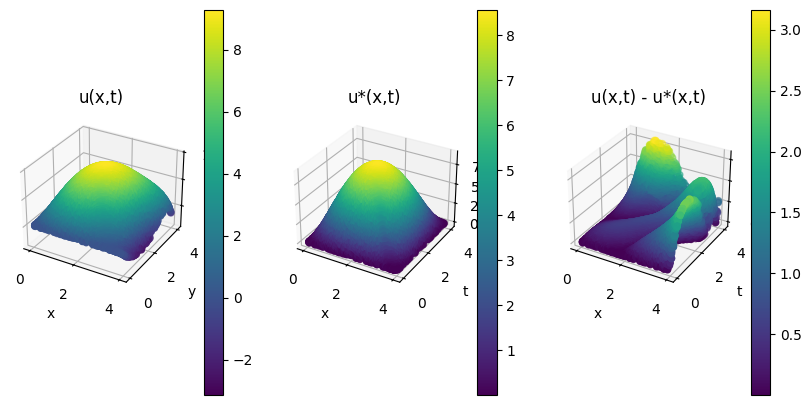

In [34]:
import matplotlib.pyplot as plt

with torch.no_grad():
  xt = generate_collocation_data(10_000, boundary,partial(gen_sample, strategy='uniform'))
  xt[:,2] = 2.5 * torch.ones(xt.shape[0])
  u_pred = model(xt.to(device)).detach().cpu().squeeze(-1).numpy()
  u_true = problem.analytical_u(xt).detach().cpu().squeeze(-1).numpy()
  abs_diff = np.abs(u_true-u_pred)

  fig = plt.figure(figsize=(10, 5))
  ax1 = fig.add_subplot(1,3,1,projection='3d')
  sc = ax1.scatter(xt[:,0],xt[:,1], u_pred, c=u_pred)
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.set_title('u(x,t)')

  plt.colorbar(sc, ax=ax1)
  # plt.colorbar(

  ax2 = fig.add_subplot(1,3,2,projection='3d')
  sc = ax2.scatter(xt[:,0],xt[:,1],u_true,c=u_true)
  # ax2.colorbar()
  ax2.set_xlabel('x')
  ax2.set_ylabel('t')
  ax2.set_title('u*(x,t)')

  plt.colorbar(sc, ax=ax2)

  ax3 = fig.add_subplot(1,3,3,projection='3d')

  sc = ax3.scatter(xt[:,0],xt[:,1],abs_diff,c=abs_diff)
  # ax3.colorbar()
  ax3.set_xlabel('x')
  ax3.set_ylabel('t')
  ax3.set_title('u(x,t) - u*(x,t)')

  plt.colorbar(sc, ax=ax3)
  plt.show()



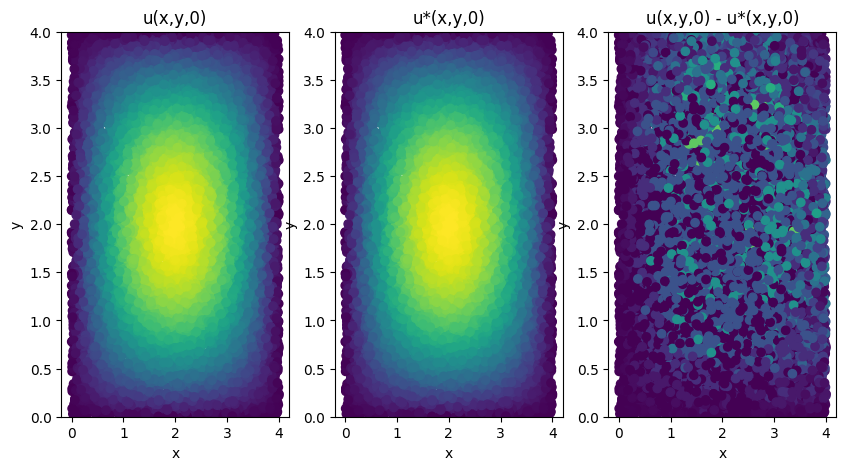

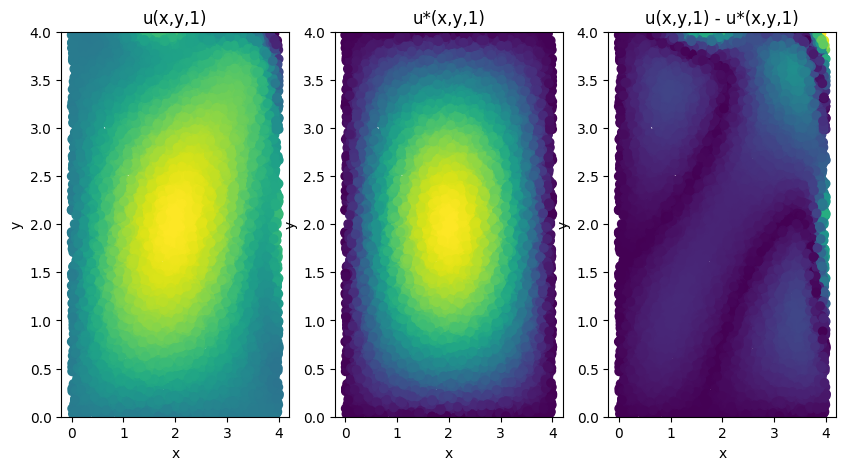

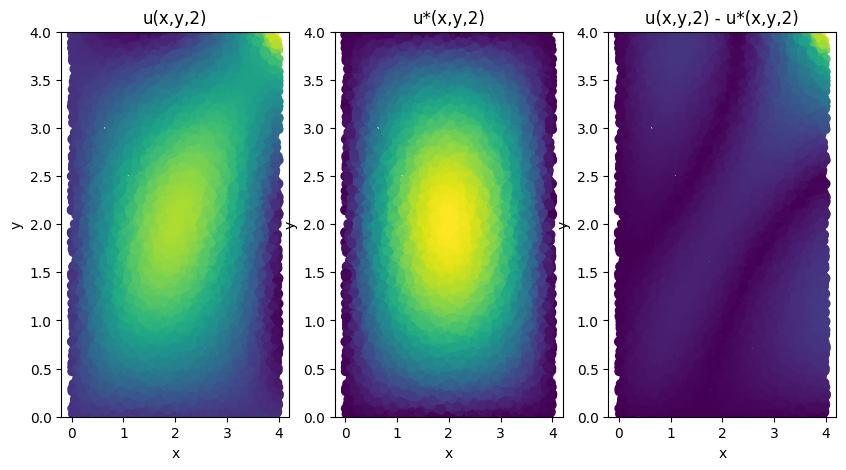

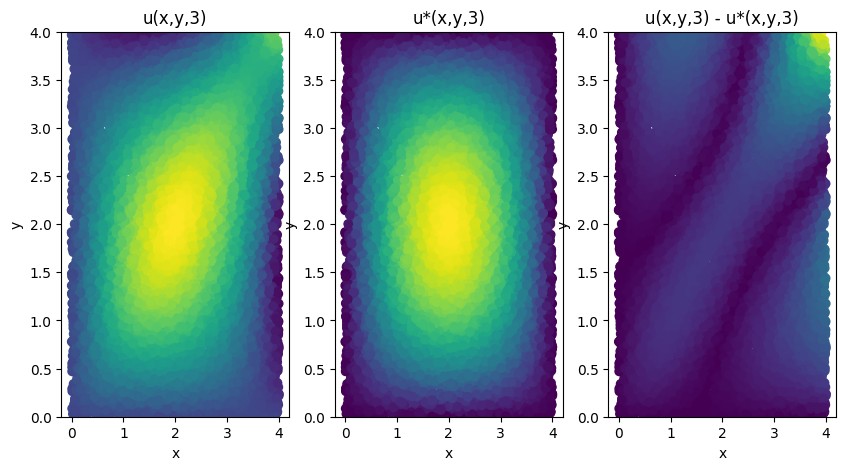

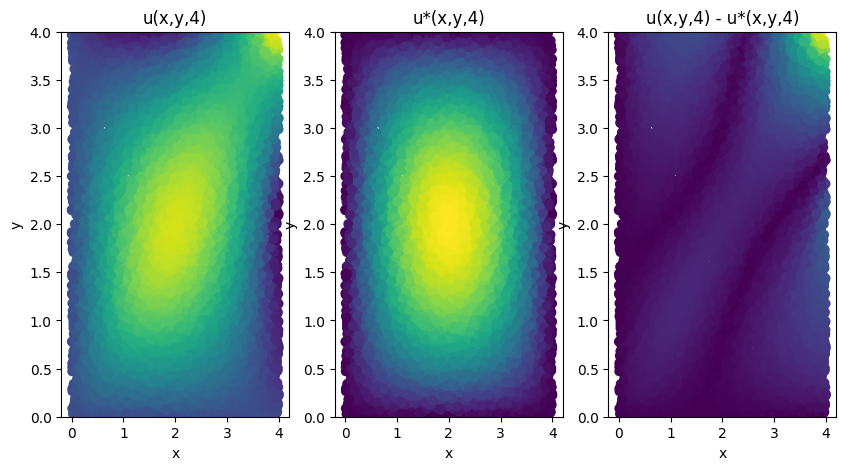

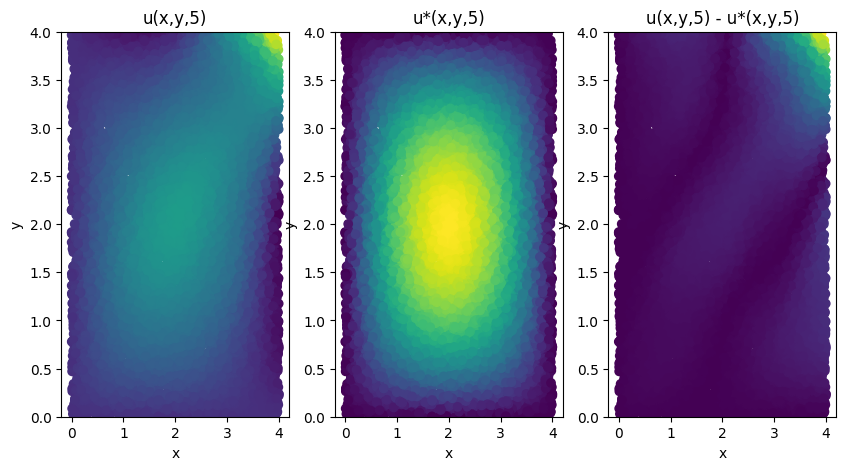

In [43]:
def visualize(model):
  with torch.no_grad():
    xt_eval = generate_collocation_data(10_000, boundary,partial(gen_sample, strategy='uniform'))
    # sort
    #xt_eval, _ = xt_eval.sort(dim=0)
    for ti in range(6):
      xt_eval[:,2] = ti * torch.ones(xt_eval.shape[0])

      u_pred = model(xt_eval.to(device)).detach().cpu().numpy()
      u_true = problem.analytical_u(xt_eval).detach().cpu().numpy()
      abs_diff = np.abs(u_true-u_pred)
      fig = plt.figure(figsize=(10, 5))


      ax1 = fig.add_subplot(1,3,1)
      ax1.scatter(xt_eval[:,0],xt_eval[:,1], c=u_pred)
      ax1.set_xlabel('x')
      ax1.set_ylabel('y')
      ax1.set_ylim(-0.,4.)
      ax1.set_title(f'u(x,y,{ti})')

      #plt.colorbar(sc, ax=ax1)
      # plt.colorbar(

      ax2 = fig.add_subplot(1,3,2)
      ax2.scatter(xt_eval[:,0],xt_eval[:,1], c=u_true)
      # ax2.colorbar()
      ax2.set_xlabel('x')
      ax2.set_ylabel('y')
      ax2.set_ylim(-0.,4.)
      ax2.set_title(f'u*(x,y,{ti})')


      ax3 = fig.add_subplot(1,3,3)

      ax3.scatter(xt_eval[:,0],xt_eval[:,1], c=abs_diff)
      # ax3.colorbar()
      ax3.set_xlabel('x')
      ax3.set_ylabel('y')
      ax3.set_ylim(-0.,4.)
      ax3.set_title(f'u(x,y,{ti}) - u*(x,y,{ti})')

      plt.show()

visualize(model)